In [1]:
# import library
import yfinance as yf
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Dropout, LeakyReLU, Activation
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [2]:
# get stock data
def get_data(stk_name, start_date):
    data = yf.download(stk_name, start=start_date, end="2018-12-31")
    return data

In [3]:
# plot graph of raw stock data
def plot_data(stk, stk_name):
    close = stk['Close']
    ax = close.plot(title=stk_name)
    ax.set_xlabel('Date')
    ax.set_ylabel('Close')
    plt.show()

In [4]:
# set train and test data
def train_test_data(stk, look_back):
    # get only close price
    data = stk.filter(['Close'])

    # numpy array
    dataset = data.values

    # train:test = 80:20
    training_data_len = math.ceil(len(dataset) * 0.8)
    training_data_len
    
    # Scaling
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)
    
    # train data 80%
    train_data = scaled_data[:training_data_len, :]

    x_train = [] 
    y_train = []

    # x_train = look back days, y_train = predict next day
    for i in range(look_back, len(train_data)):
        x_train.append(train_data[i-look_back:i, 0])
        y_train.append(train_data[i, 0])
    
    # numpy array
    x_train, y_train = np.array(x_train), np.array(y_train)
    
    # reshape
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
    
    # test data 20%
    test_data = scaled_data[training_data_len - look_back: , :] 

    x_test = [] 
    y_test = dataset[training_data_len: :]

    for i in range(look_back, len(test_data)):
        x_test.append(test_data[i-look_back:i, 0])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    return x_train, y_train, x_test, y_test, data, training_data_len, scaler

In [5]:
# develop LSTM model
def model(x_train, y_train, x_test, y_test, optimizer, epochs, scaler):

    # Initial
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    # Train model
    model.fit(x_train, y_train, batch_size=1, epochs=epochs)
    
    # Predict model
    predictions = model.predict(x_test)

    # Transform scaler
    predictions = scaler.inverse_transform(predictions)
    
    # Root mean squared error
    rmse = np.sqrt(np.mean(predictions - y_test)**2)
    
    # MAPE
    mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100 
    
    print("Optimizer = {}, epochs = {}, rmse = {}, mape = {}".format(optimizer, epochs, rmse, mape))
    
    return predictions

In [6]:
# develop CNN model (New)
def cnn_model(x_train, y_train, x_test, y_test, optimizer, epochs, scaler):
    # Parameters
    nFeatures = x_train.shape[1]
    batchSize = 1000
    nOutput = 1
    kernelSize = 1
    
    # Model Building
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=kernelSize, padding='same', activation='relu', input_shape=(nFeatures, 1)))
    model.add(Conv1D(filters=64, kernel_size=kernelSize, padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(MaxPooling1D(pool_size=(1)))
    model.add(Conv1D(filters=128, kernel_size=kernelSize, padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Flatten())
    model.add(Dense(256,))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.8))
    model.add(Dense(nOutput, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()

    # Train model
    fitReturn = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=batchSize, verbose=1)
    
    # Predict model
    predictions = model.predict(x_test, verbose=0)
    
    # Transform scaler
    predictions = scaler.inverse_transform(predictions)
    
    # Root mean squared error
    rmse = np.sqrt(np.mean(predictions - y_test)**2)
    
    # MAPE
    mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100 
    
    print("Optimizer = {}, epochs = {}, rmse = {}, mape = {}".format(optimizer, epochs, rmse, mape))
    
    return predictions

In [7]:
# develop CNN model (Thesis)
def thesis_cnn_model(x_train, y_train, x_test, y_test, optimizer, epochs, scaler):
    # Parameters
    nFeatures = x_train.shape[1]
    batchSize = 1000
    nOutput = 1
    kernelSize = 1
    
    # Model Building
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=kernelSize, padding='same', activation='relu', input_shape=(nFeatures, 1)))
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(Conv1D(filters=64, kernel_size=kernelSize, padding='same'))
    model.add(MaxPooling1D(pool_size=(2)))
    model.add(Dropout(0.8))
    model.add(Flatten())
    model.add(Dense(256,))
    model.add(Dropout(0.8))
    model.add(Activation('relu'))
    model.add(Dense(256,))
    model.add(Activation('relu'))
    model.add(Dense(nOutput, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()

    # Train model
    fitReturn = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=batchSize, verbose=1)
    
    # Predict model
    predictions = model.predict(x_test, verbose=0)
    
    # Transform scaler
    predictions = scaler.inverse_transform(predictions)
    
    # Root mean squared error
    rmse = np.sqrt(np.mean(predictions - y_test)**2)
    
    # MAPE
    mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100 
    
    print("Optimizer = {}, epochs = {}, rmse = {}, mape = {}".format(optimizer, epochs, rmse, mape))
    
    return predictions

In [8]:
# draw a graph of predict data
def plot_graph(data, predictions, training_data_len):
    
    # plot existing stock with predict stock
    train = data[:training_data_len]
    valid = data[training_data_len:]
    valid['Predictions'] = predictions

    plt.figure(figsize=(7,5))
    plt.title('Model')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price', fontsize=18)
    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'] , loc='lower right')
    plt.show()

    return valid

# CPALL (CP All PCL)

[*********************100%***********************]  1 of 1 completed


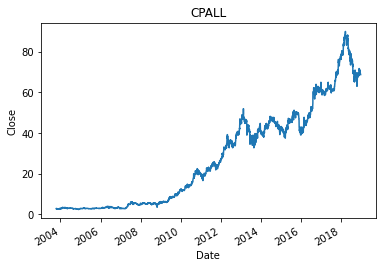

In [9]:
# get stock data (2001)
df_CPALL = get_data("CPALL.BK", "2001-01-01")

# draw data graph
plot_data(df_CPALL, "CPALL")

In [10]:
df_CPALL

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-10-14,3.000,3.10,2.775,2.80,1.612804,46761900
2003-10-15,2.850,2.90,2.825,2.85,1.641604,1126730000
2003-10-16,2.875,2.90,2.850,2.85,1.641604,661310000
2003-10-17,2.850,3.00,2.850,2.95,1.699204,971240000
2003-10-20,2.975,3.00,2.900,2.90,1.670404,228750000
...,...,...,...,...,...,...
2018-12-24,69.250,69.75,69.250,69.50,63.704311,8806300
2018-12-25,69.000,69.25,68.500,69.00,63.246002,13892900
2018-12-26,69.000,69.25,68.500,69.00,63.246002,24368000


In [27]:
# set train and test data for 30 look back
x_train, y_train, x_test, y_test, data, training_data_len, scaler = train_test_data(df_CPALL, 30)

In [28]:
# predict LSTM model with 30 look back
predictions = model(x_train, y_train, x_test, y_test, 'adam', 1, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'adam', 10, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'adam', 20, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'adam', 30, scaler)

predictions = model(x_train, y_train, x_test, y_test, 'sgd', 1, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler)

predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 1, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler)

Epoch 1/10
2962/2962 [==============================] - 48s 14ms/step - loss: 7.2578e-04
Epoch 2/10
2962/2962 [==============================] - 43s 14ms/step - loss: 2.5906e-04
Epoch 3/10
2962/2962 [==============================] - 45s 15ms/step - loss: 1.9212e-04
Epoch 4/10
2962/2962 [==============================] - 54s 18ms/step - loss: 1.6052e-04
Epoch 5/10
2962/2962 [==============================] - 57s 19ms/step - loss: 1.3438e-04
Epoch 6/10
2962/2962 [==============================] - 54s 18ms/step - loss: 1.2297e-04
Epoch 7/10
2962/2962 [==============================] - 55s 18ms/step - loss: 1.1270e-04
Epoch 8/10
2962/2962 [==============================] - 56s 19ms/step - loss: 1.0068e-04
Epoch 9/10
2962/2962 [==============================] - 48s 16ms/step - loss: 9.4914e-05
Epoch 10/10
24/24 [==============================] - 3s 11ms/step
Optimizer = rmsprop, epochs = 10, rmse = 0.9925377014650398, mape = 2.000906079021218


In [ ]:
# set train and test data for 60 look back
x_train, y_train, x_test, y_test, data, training_data_len, scaler = train_test_data(df_CPALL, 60)

In [ ]:
# predict LSTM model with 60 look back
predictions = model(x_train, y_train, x_test, y_test, 'adam', 1, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'adam', 10, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'adam', 20, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'adam', 30, scaler)

predictions = model(x_train, y_train, x_test, y_test, 'sgd', 1, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler)

predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 1, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler)

In [ ]:
# predict thesis CNN model
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 10, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 20, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 30, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 100, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 200, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 300, scaler, 3)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 10, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 20, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 30, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 100, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 200, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 300, scaler, 5)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 10, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 20, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 30, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 100, scaler, 7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 200, scaler, 7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 300, scaler, 7)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 100, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 200, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 300, scaler, 3)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 100, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 200, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 300, scaler, 5)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 100, scaler, 7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 200, scaler, 7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 300, scaler, 7)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 100, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 200, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 300, scaler, 3)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 100, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 200, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 300, scaler, 5)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 100, scaler, 7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 200, scaler, 7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 300, scaler, 7)

In [ ]:
# predict new CNN model
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 10, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 20, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 30, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 100, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 200, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 300, scaler, 3)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 10, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 20, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 30, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 100, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 200, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 300, scaler, 5)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 10, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 20, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 30, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 100, scaler, 7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 200, scaler, 7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 300, scaler, 7)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 100, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 200, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 300, scaler, 3)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 100, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 200, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 300, scaler, 5)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 100, scaler, 7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 200, scaler, 7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 300, scaler, 7)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 100, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 200, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 300, scaler, 3)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 100, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 200, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 300, scaler, 5)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 100, scaler, 7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 200, scaler, 7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 300, scaler, 7)

C:\Users\TEEM\AppData\Local\Temp\ipykernel_94812\1868488282.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


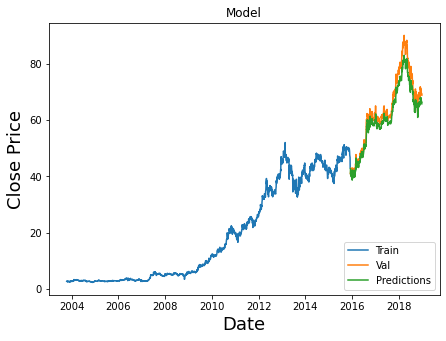

In [12]:
# draw prediction graph
valid = plot_graph(data, predictions, training_data_len)

In [ ]:
# show prediction data
valid

[*********************100%***********************]  1 of 1 completed


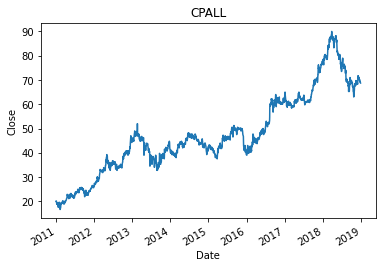

In [29]:
# get stock data (2011)
df_CPALL = get_data("CPALL.BK", "2011-01-01")

# draw data graph
plot_data(df_CPALL, "CPALL")

In [30]:
# set train and test data for 30 look back
x_train, y_train, x_test, y_test, data, training_data_len, scaler = train_test_data(df_CPALL, 30)

In [31]:
# predict LSTM model with 30 look back
predictions = model(x_train, y_train, x_test, y_test, 'adam', 1, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'adam', 10, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'adam', 20, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'adam', 30, scaler)

predictions = model(x_train, y_train, x_test, y_test, 'sgd', 1, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler)

predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 1, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler)

13/13 [==============================] - 2s 9ms/step
Optimizer = adam, epochs = 1, rmse = 0.8333197373610276, mape = 1.7940779349869547


In [ ]:
# set train and test data for 60 look back
x_train, y_train, x_test, y_test, data, training_data_len, scaler = train_test_data(df_CPALL, 60)

In [ ]:
# predict LSTM model with 60 look back
predictions = model(x_train, y_train, x_test, y_test, 'adam', 1, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'adam', 10, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'adam', 20, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'adam', 30, scaler)

predictions = model(x_train, y_train, x_test, y_test, 'sgd', 1, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler)

predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 1, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler)

In [ ]:
# predict thesis CNN model
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 10, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 20, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 30, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 100, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 200, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 300, scaler, 3)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 10, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 20, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 30, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 100, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 200, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 300, scaler, 5)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 10, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 20, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 30, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 100, scaler, 7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 200, scaler, 7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 300, scaler, 7)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 100, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 200, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 300, scaler, 3)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 100, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 200, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 300, scaler, 5)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 100, scaler, 7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 200, scaler, 7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 300, scaler, 7)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 100, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 200, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 300, scaler, 3)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 100, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 200, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 300, scaler, 5)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 100, scaler, 7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 200, scaler, 7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 300, scaler, 7)

In [ ]:
# predict new CNN model
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 10, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 20, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 30, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 100, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 200, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 300, scaler, 3)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 10, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 20, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 30, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 100, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 200, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 300, scaler, 5)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 10, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 20, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 30, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 100, scaler, 7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 200, scaler, 7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 300, scaler, 7)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 100, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 200, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 300, scaler, 3)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 100, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 200, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 300, scaler, 5)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 100, scaler, 7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 200, scaler, 7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 300, scaler, 7)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 100, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 200, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 300, scaler, 3)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 100, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 200, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 300, scaler, 5)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 100, scaler, 7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 200, scaler, 7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 300, scaler, 7)

C:\Users\TEEM\AppData\Local\Temp\ipykernel_94812\1868488282.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


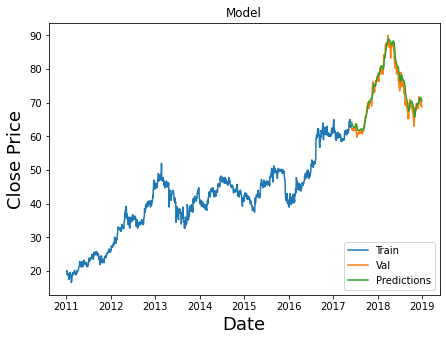

In [32]:
# draw prediction graph
valid = plot_graph(data, predictions, training_data_len)

In [ ]:
# show prediction data
valid

# AOT (Airports of Thailand PCL)

[*********************100%***********************]  1 of 1 completed


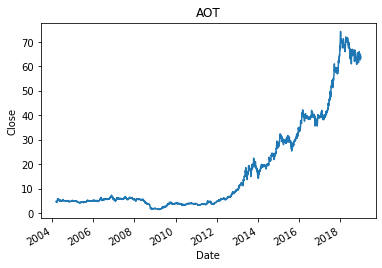

In [17]:
# get stock data (2001)
df_AOT = get_data("AOT.BK", "2001-01-01")

# draw data graph
plot_data(df_AOT, "AOT")

In [18]:
# set train and test data for 30 look back
x_train, y_train, x_test, y_test, data, training_data_len, scaler = train_test_data(df_AOT, 30)

In [19]:
# predict LSTM model with 30 look back
predictions = model(x_train, y_train, x_test, y_test, 'adam', 1, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'adam', 10, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'adam', 20, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'adam', 30, scaler)

predictions = model(x_train, y_train, x_test, y_test, 'sgd', 1, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler)

predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 1, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler)

23/23 [==============================] - 2s 9ms/step
Optimizer = rmsprop, epochs = 1, rmse = 0.5178457861077296, mape = 2.938334038271158


In [ ]:
# set train and test data for 60 look back
x_train, y_train, x_test, y_test, data, training_data_len, scaler = train_test_data(df_AOT, 60)

In [11]:
# predict LSTM model with 60 look back
predictions = model(x_train, y_train, x_test, y_test, 'adam', 1, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'adam', 10, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'adam', 20, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'adam', 30, scaler)

predictions = model(x_train, y_train, x_test, y_test, 'sgd', 1, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler)

predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 1, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler)

23/23 [==============================] - 1s 11ms/step
Optimizer = adam, epochs = 1, rmse = 2.7009599711797008, mape = 4.916445474671951
Epoch 1/10
2862/2862 [==============================] - 92s 31ms/step - loss: 2.8512e-04
Epoch 2/10
2862/2862 [==============================] - 81s 28ms/step - loss: 1.2091e-04
Epoch 3/10
2862/2862 [==============================] - 68s 24ms/step - loss: 9.9458e-05
Epoch 4/10
2862/2862 [==============================] - 68s 24ms/step - loss: 6.1835e-05
Epoch 5/10
2862/2862 [==============================] - 67s 24ms/step - loss: 6.5931e-05
Epoch 6/10
2862/2862 [==============================] - 66s 23ms/step - loss: 4.7243e-05
Epoch 7/10
2862/2862 [==============================] - 73s 25ms/step - loss: 5.5004e-05
Epoch 8/10
2862/2862 [==============================] - 66s 23ms/step - loss: 4.4787e-05
Epoch 9/10
2862/2862 [==============================] - 67s 23ms/step - loss: 4.7900e-05
Epoch 10/10
23/23 [==============================] - 3s 17ms/st

C:\Users\TEEM\AppData\Local\Temp\ipykernel_72204\2295167687.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


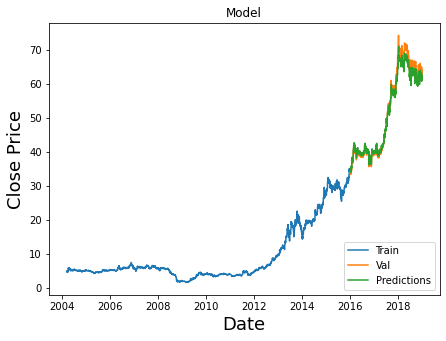

In [12]:
# predict thesis CNN model
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 10, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 20, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 30, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 100, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 200, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 300, scaler, 3)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 10, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 20, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 30, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 100, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 200, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 300, scaler, 5)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 10, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 20, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 30, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 100, scaler, 7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 200, scaler, 7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 300, scaler, 7)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 100, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 200, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 300, scaler, 3)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 100, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 200, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 300, scaler, 5)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 100, scaler, 7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 200, scaler, 7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 300, scaler, 7)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 100, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 200, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 300, scaler, 3)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 100, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 200, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 300, scaler, 5)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 100, scaler, 7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 200, scaler, 7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 300, scaler, 7)

In [13]:
# predict new CNN model
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 10, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 20, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 30, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 100, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 200, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 300, scaler, 3)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 10, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 20, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 30, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 100, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 200, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 300, scaler, 5)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 10, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 20, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 30, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 100, scaler, 7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 200, scaler, 7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 300, scaler, 7)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 100, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 200, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 300, scaler, 3)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 100, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 200, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 300, scaler, 5)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 100, scaler, 7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 200, scaler, 7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 300, scaler, 7)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 100, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 200, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 300, scaler, 3)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 100, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 200, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 300, scaler, 5)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 100, scaler, 7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 200, scaler, 7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 300, scaler, 7)

23/23 [==============================] - 7s 25ms/step
Optimizer = sgd, epochs = 1, rmse = 4.635208756956335, mape = 7.98886185327871
Epoch 1/10
2862/2862 [==============================] - 138s 42ms/step - loss: 0.0022
Epoch 2/10
2862/2862 [==============================] - 116s 41ms/step - loss: 7.2279e-05
Epoch 3/10
2862/2862 [==============================] - 117s 41ms/step - loss: 7.1779e-05
Epoch 4/10
2862/2862 [==============================] - 137s 48ms/step - loss: 7.2061e-05
Epoch 5/10
2862/2862 [==============================] - 128s 45ms/step - loss: 7.1639e-05
Epoch 6/10
2862/2862 [==============================] - 124s 43ms/step - loss: 7.0800e-05
Epoch 7/10
2862/2862 [==============================] - 121s 42ms/step - loss: 6.9292e-05
Epoch 8/10
2862/2862 [==============================] - 108s 38ms/step - loss: 7.0257e-05
Epoch 9/10
2862/2862 [==============================] - 101s 35ms/step - loss: 6.8481e-05
Epoch 10/10
23/23 [==============================] - 11s 21ms

C:\Users\TEEM\AppData\Local\Temp\ipykernel_94812\1868488282.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


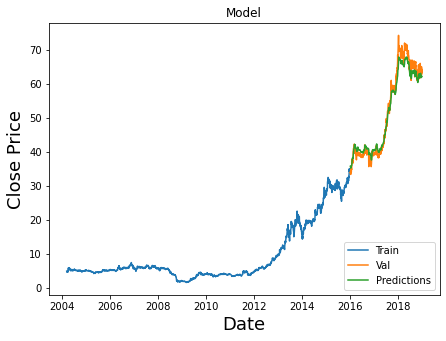

In [20]:
# draw prediction graph
valid = plot_graph(data, predictions, training_data_len)

In [15]:
# show prediction data
valid

23/23 [==============================] - 8s 21ms/step
Optimizer = rmsprop, epochs = 1, rmse = 5.037604700375909, mape = 9.805129571353902
Epoch 1/10
2862/2862 [==============================] - 145s 38ms/step - loss: 4.1618e-04
Epoch 2/10
2862/2862 [==============================] - 110s 39ms/step - loss: 1.6714e-04
Epoch 3/10
2862/2862 [==============================] - 101s 35ms/step - loss: 1.1508e-04
Epoch 4/10
2862/2862 [==============================] - 99s 34ms/step - loss: 8.9481e-05
Epoch 5/10
2862/2862 [==============================] - 112s 39ms/step - loss: 7.5875e-05
Epoch 6/10
2862/2862 [==============================] - 111s 39ms/step - loss: 7.0103e-05
Epoch 7/10
2862/2862 [==============================] - 110s 38ms/step - loss: 6.3468e-05
Epoch 8/10
2862/2862 [==============================] - 110s 38ms/step - loss: 5.6528e-05
Epoch 9/10
2862/2862 [==============================] - 99s 35ms/step - loss: 5.3441e-05
Epoch 10/10
23/23 [==============================] - 4

[*********************100%***********************]  1 of 1 completed


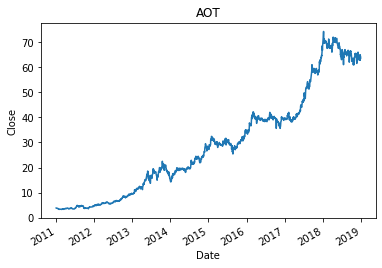

In [23]:
# get stock data (2011)
df_AOT = get_data("AOT.BK", "2011-01-01")

# draw data graph
plot_data(df_AOT, "AOT")

In [24]:
# set train and test data for 30 look back
x_train, y_train, x_test, y_test, data, training_data_len, scaler = train_test_data(df_AOT, 30)

In [ ]:
# predict LSTM model with 30 look back
predictions = model(x_train, y_train, x_test, y_test, 'adam', 1, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'adam', 10, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'adam', 20, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'adam', 30, scaler)

predictions = model(x_train, y_train, x_test, y_test, 'sgd', 1, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler)

predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 1, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler)

In [ ]:
# set train and test data for 60 look back
x_train, y_train, x_test, y_test, data, training_data_len, scaler = train_test_data(df_AOT, 60)

C:\Users\TEEM\AppData\Local\Temp\ipykernel_25864\514960936.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


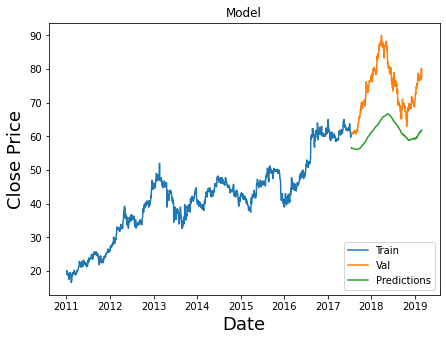

,Close,Predictions
Date,,
2017-07-17,61.00,56.512398
2017-07-18,61.00,56.466599
2017-07-19,61.00,56.496849
2017-07-20,61.00,56.478039
2017-07-21,60.75,56.500103
...,...,...
2019-02-22,78.75,61.555527
2019-02-25,80.25,61.704483
2019-02-26,80.00,61.705154


In [16]:
# predict LSTM model with 60 look back
predictions = model(x_train, y_train, x_test, y_test, 'adam', 1, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'adam', 10, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'adam', 20, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'adam', 30, scaler)

predictions = model(x_train, y_train, x_test, y_test, 'sgd', 1, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler)

predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 1, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler)

In [ ]:
# predict thesis CNN model
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 10, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 20, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 30, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 100, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 200, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 300, scaler, 3)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 10, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 20, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 30, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 100, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 200, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 300, scaler, 5)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 10, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 20, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 30, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 100, scaler, 7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 200, scaler, 7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 300, scaler, 7)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 100, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 200, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 300, scaler, 3)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 100, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 200, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 300, scaler, 5)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 100, scaler, 7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 200, scaler, 7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 300, scaler, 7)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 100, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 200, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 300, scaler, 3)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 100, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 200, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 300, scaler, 5)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 100, scaler, 7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 200, scaler, 7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 300, scaler, 7)

In [ ]:
# predict new CNN model
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 10, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 20, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 30, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 100, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 200, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 300, scaler, 3)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 10, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 20, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 30, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 100, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 200, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 300, scaler, 5)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 10, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 20, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 30, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 100, scaler, 7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 200, scaler, 7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 300, scaler, 7)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 100, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 200, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 300, scaler, 3)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 100, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 200, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 300, scaler, 5)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 100, scaler, 7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 200, scaler, 7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 300, scaler, 7)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 100, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 200, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 300, scaler, 3)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 100, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 200, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 300, scaler, 5)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 100, scaler, 7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 200, scaler, 7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 300, scaler, 7)

In [ ]:
# draw prediction graph
valid = plot_graph(data, predictions, training_data_len)

In [ ]:
# show prediction data
valid

# LH (Land & Houses Public Company Limited)

[*********************100%***********************]  1 of 1 completed


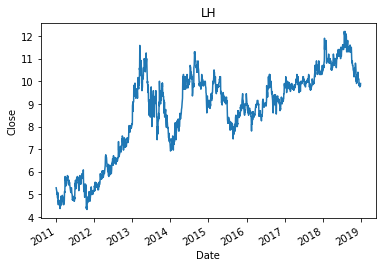

In [31]:
# get stock data (2001)
df_LH = get_data("LH.BK", "2001-01-01")

# draw data graph
plot_data(df_LH, "LH")

In [ ]:
# set train and test data for 30 look back
x_train, y_train, x_test, y_test, data, training_data_len, scaler = train_test_data(df_LH, 30)

In [ ]:
# predict LSTM model with 30 look back
predictions = model(x_train, y_train, x_test, y_test, 'adam', 1, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'adam', 10, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'adam', 20, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'adam', 30, scaler)

predictions = model(x_train, y_train, x_test, y_test, 'sgd', 1, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler)

predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 1, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler)

In [ ]:
# set train and test data for 60 look back
x_train, y_train, x_test, y_test, data, training_data_len, scaler = train_test_data(df_LH, 60)

In [ ]:
# predict LSTM model with 60 look back
predictions = model(x_train, y_train, x_test, y_test, 'adam', 1, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'adam', 10, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'adam', 20, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'adam', 30, scaler)

predictions = model(x_train, y_train, x_test, y_test, 'sgd', 1, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler)

predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 1, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler)

In [36]:
# predict thesis CNN model
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 10, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 20, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 30, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 100, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 200, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 300, scaler, 3)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 10, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 20, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 30, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 100, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 200, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 300, scaler, 5)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 10, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 20, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 30, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 100, scaler, 7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 200, scaler, 7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 300, scaler, 7)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 100, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 200, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 300, scaler, 3)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 100, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 200, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 300, scaler, 5)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 100, scaler, 7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 200, scaler, 7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 300, scaler, 7)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 100, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 200, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 300, scaler, 3)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 100, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 200, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 300, scaler, 5)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 100, scaler, 7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 200, scaler, 7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 300, scaler, 7)

13/13 [==============================] - 3s 21ms/step
Optimizer = adam, epochs = 1, rmse = 0.06390775778354743, mape = 1.517013503356091


C:\Users\TEEM\AppData\Local\Temp\ipykernel_72204\2295167687.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


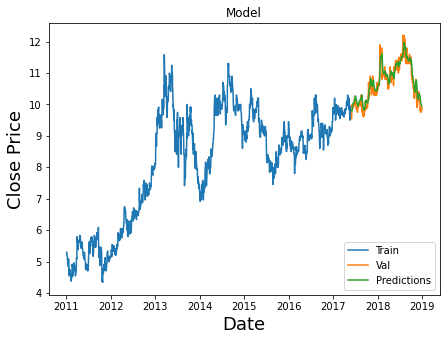

In [37]:
# predict new CNN model
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 10, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 20, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 30, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 100, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 200, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 300, scaler, 3)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 10, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 20, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 30, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 100, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 200, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 300, scaler, 5)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 10, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 20, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 30, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 100, scaler, 7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 200, scaler, 7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 300, scaler, 7)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 100, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 200, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 300, scaler, 3)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 100, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 200, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 300, scaler, 5)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 100, scaler, 7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 200, scaler, 7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 300, scaler, 7)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 100, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 200, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 300, scaler, 3)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 100, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 200, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 300, scaler, 5)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 100, scaler, 7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 200, scaler, 7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 300, scaler, 7)

In [27]:
# draw prediction graph
valid = plot_graph(data, predictions, training_data_len)

29/29 [==============================] - 16s 29ms/step
Optimizer = sgd, epochs = 1, rmse = 0.230157461453441, mape = 3.072217626301162
Epoch 1/10
3528/3528 [==============================] - 227s 49ms/step - loss: 0.0031
Epoch 2/10
3528/3528 [==============================] - 174s 49ms/step - loss: 0.0014
Epoch 3/10
3528/3528 [==============================] - 189s 54ms/step - loss: 0.0013
Epoch 4/10
3528/3528 [==============================] - 162s 46ms/step - loss: 0.0012
Epoch 5/10
3528/3528 [==============================] - 187s 53ms/step - loss: 0.0011
Epoch 6/10
3528/3528 [==============================] - 182s 52ms/step - loss: 0.0011
Epoch 7/10
3528/3528 [==============================] - 145s 41ms/step - loss: 0.0010
Epoch 8/10
3528/3528 [==============================] - 142s 40ms/step - loss: 9.6112e-04
Epoch 9/10
3528/3528 [==============================] - 150s 43ms/step - loss: 9.3280e-04
Epoch 10/10
29/29 [==============================] - 6s 27ms/step
Optimizer = sgd, 

C:\Users\TEEM\AppData\Local\Temp\ipykernel_72204\2295167687.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


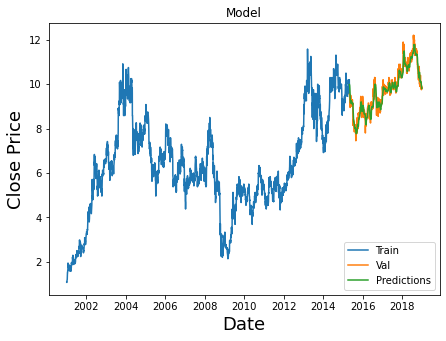

In [28]:
# show prediction data
valid

In [29]:
# get stock data (2011)
df_LH = get_data("LH.BK", "2011-01-01")

# draw data graph
plot_data(df_LH, "LH")

29/29 [==============================] - 9s 26ms/step
Optimizer = rmsprop, epochs = 1, rmse = 0.21815667051402488, mape = 2.3381156757873174
Epoch 1/10
3528/3528 [==============================] - 176s 41ms/step - loss: 0.0017
Epoch 2/10
3528/3528 [==============================] - 150s 42ms/step - loss: 6.3567e-04
Epoch 3/10
3528/3528 [==============================] - 151s 43ms/step - loss: 5.6887e-04
Epoch 4/10
3528/3528 [==============================] - 151s 43ms/step - loss: 5.1274e-04
Epoch 5/10
3528/3528 [==============================] - 155s 44ms/step - loss: 4.7954e-04
Epoch 6/10
3528/3528 [==============================] - 142s 40ms/step - loss: 4.7037e-04
Epoch 7/10
3528/3528 [==============================] - 143s 40ms/step - loss: 4.5300e-04
Epoch 8/10
3528/3528 [==============================] - 153s 43ms/step - loss: 4.3652e-04
Epoch 9/10
3528/3528 [==============================] - 150s 43ms/step - loss: 4.2029e-04
Epoch 10/10
29/29 [==============================] - 

C:\Users\TEEM\AppData\Local\Temp\ipykernel_72204\2295167687.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


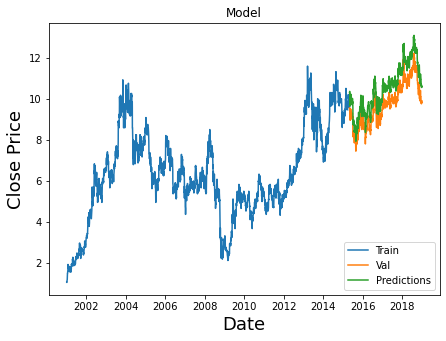

In [30]:
# set train and test data for 30 look back
x_train, y_train, x_test, y_test, data, training_data_len, scaler = train_test_data(df_LH, 30)

In [ ]:
# predict LSTM model with 30 look back
predictions = model(x_train, y_train, x_test, y_test, 'adam', 1, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'adam', 10, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'adam', 20, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'adam', 30, scaler)

predictions = model(x_train, y_train, x_test, y_test, 'sgd', 1, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler)

predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 1, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler)

In [ ]:
# set train and test data for 60 look back
x_train, y_train, x_test, y_test, data, training_data_len, scaler = train_test_data(df_LH, 60)

In [ ]:
# predict LSTM model with 60 look back
predictions = model(x_train, y_train, x_test, y_test, 'adam', 1, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'adam', 10, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'adam', 20, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'adam', 30, scaler)

predictions = model(x_train, y_train, x_test, y_test, 'sgd', 1, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler)

predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 1, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler)
predictions = model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler)

In [ ]:
# predict thesis CNN model
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 10, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 20, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 30, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 100, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 200, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 300, scaler, 3)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 10, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 20, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 30, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 100, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 200, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 300, scaler, 5)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 10, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 20, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 30, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 100, scaler, 7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 200, scaler, 7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'adam', 300, scaler, 7)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 100, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 200, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 300, scaler, 3)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 100, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 200, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 300, scaler, 5)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 100, scaler, 7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 200, scaler, 7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'sgd', 300, scaler, 7)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 100, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 200, scaler, 3)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 300, scaler, 3)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 100, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 200, scaler, 5)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 300, scaler, 5)

predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler,  7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 100, scaler, 7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 200, scaler, 7)
predictions = thesis_cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 300, scaler, 7)

In [ ]:
# predict new CNN model
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 10, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 20, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 30, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 100, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 200, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 300, scaler, 3)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 10, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 20, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 30, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 100, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 200, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 300, scaler, 5)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 10, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 20, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 30, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 100, scaler, 7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 200, scaler, 7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'adam', 300, scaler, 7)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 100, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 200, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 300, scaler, 3)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 100, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 200, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 300, scaler, 5)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 10, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 20, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 30, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 100, scaler, 7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 200, scaler, 7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'sgd', 300, scaler, 7)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 100, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 200, scaler, 3)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 300, scaler, 3)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 100, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 200, scaler, 5)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 300, scaler, 5)

predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 10, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 20, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 30, scaler,  7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 100, scaler, 7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 200, scaler, 7)
predictions = cnn_model(x_train, y_train, x_test, y_test, 'rmsprop', 300, scaler, 7)

In [ ]:
# draw prediction graph
valid = plot_graph(data, predictions, training_data_len)

In [ ]:
# show prediction data
valid